## Importing the libararies

In [0]:
import nltk
import pandas as pd
import re
import string 
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# initalizing the stemmer
ps = nltk.PorterStemmer()

## importng libraries for vectorizing our data
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

## importing libraries for train and test split
from sklearn.model_selection import train_test_split

## importing the model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# importing for the model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve

In [3]:
### Downloading the stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
stopwords[:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we']

## Importing the dataset

In [4]:
## sep = '/t' to seperate the lines 
data = pd.read_csv("/content/drive/My Drive/linkdin-notebook/NLP/SMSSpamCollection.tsv", sep = '\t')
data.columns = ['label','body_text']
data.head()

,label,body_text
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,ham,"Nah I don't think he goes to usf, he lives aro..."
2,ham,Even my brother is not like to speak with me. ...
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
4,ham,As per your request 'Melle Melle (Oru Minnamin...


## visualizing the data


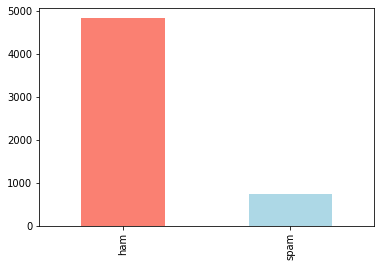

In [5]:
data["label"].value_counts().plot(kind = "bar", color = ["salmon", "lightblue"]);

In [0]:
## creating a feature body len for better visualization of spam and ham email messages
data["body_len"] = data["body_text"].apply(lambda x: len(x)-x.count(" "))


     
density : bool, optional
If True, the first element of the return tuple will be the counts normalized to form a probability density, i.e., the area (or integral) under the histogram will sum to 1. This is achieved by dividing the count by the number of observations times the bin width and not dividing by the total number of observations. If stacked is also True, the sum of the histograms is normalized to 1.

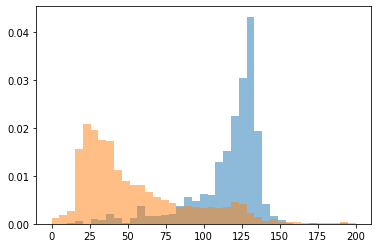

In [7]:

bins = np.linspace(0,200,40)
plt.hist(data[data["label"]=='spam']['body_len'], bins, alpha = 0.5, density = True, label = 'spam')
plt.hist(data[data["label"]=='ham']['body_len'], bins, alpha = 0.5, density = True, label = 'ham')
plt.show()

### Getting the best feature for accurate predictions

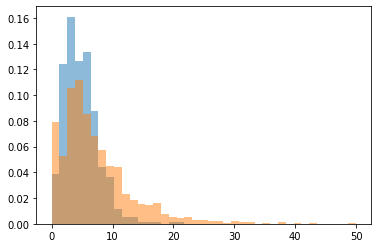

In [8]:
#### creating a feature which contains the % of text that containd punctuations
#### generally spam mails contains the large amount of punctuations 

def count_punct(text):
  count = sum([1 for char in text if char in string.punctuation])
  return round(count/(len(text)-text.count(" ")), 3)*100
  
data["punct%"] = data["body_text"].apply(lambda x:count_punct(x))

## plotting the feature
bins = np.linspace(0,50,40)
plt.hist(data[data["label"]=='spam']['punct%'], bins, alpha = 0.5, density = True, label = 'spam')
plt.hist(data[data["label"]=='ham']['punct%'], bins, alpha = 0.5, density = True, label = 'ham')
plt.show()

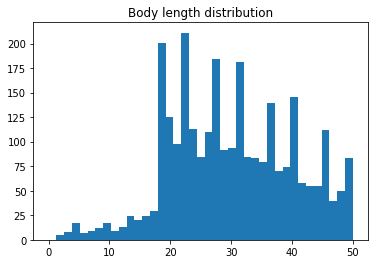

In [9]:
#### Plotting the both feature body lenght and punctuation percentage

plt.hist(data["body_len"], bins)
plt.title("Body length distribution")
plt.show()

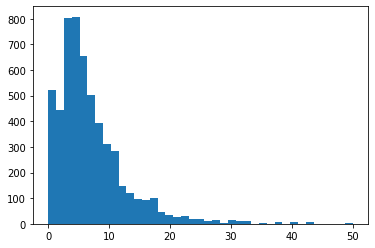

In [10]:
bins = np.linspace(0,50,40)
plt.hist(data["punct%"], bins)
#pyplot.title("Body length distribution")
plt.show()

## Transformation

#### Process that alters each data point in a certain column in a systematic way 

## Box-Cox power transformation

### process
1. determine what range of exponent to test
2. Apply each transformaation to each value of your chossen value
3. Use some criteria to determine which of the transformation yield the best distribution

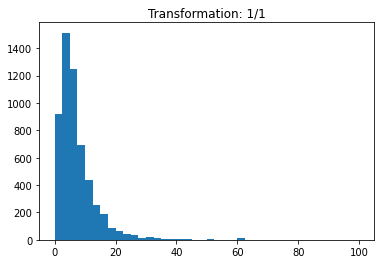

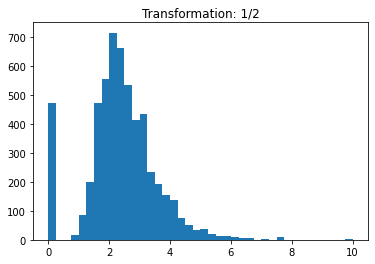

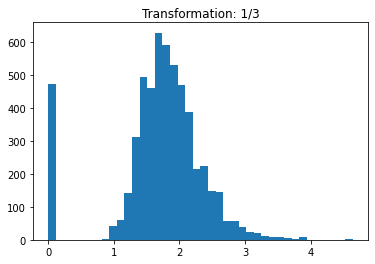

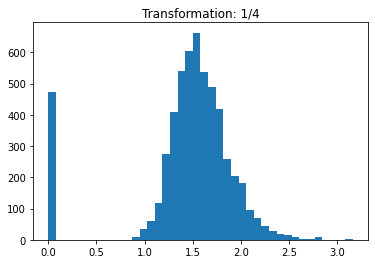

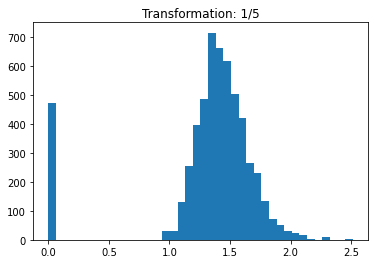

In [11]:
## for better results we are positive value for transforming 
## into the exponential power
for i in [1,2,3,4,5]:
    plt.hist((data['punct%'])**(1/i), bins=40)
    plt.title('Transformation: 1/{}'.format(str(i)))
    plt.show()

## Cleannin data
 As we define all the parameters Now we clean our body_text so that it can be vectorized

In [0]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

## Train_test_Split
 Now for better prediction we first split our data then vectorize our data

In [13]:
data.corr()

,body_len,punct%
body_len,1.000000,-0.152412
punct%,-0.152412,1.000000


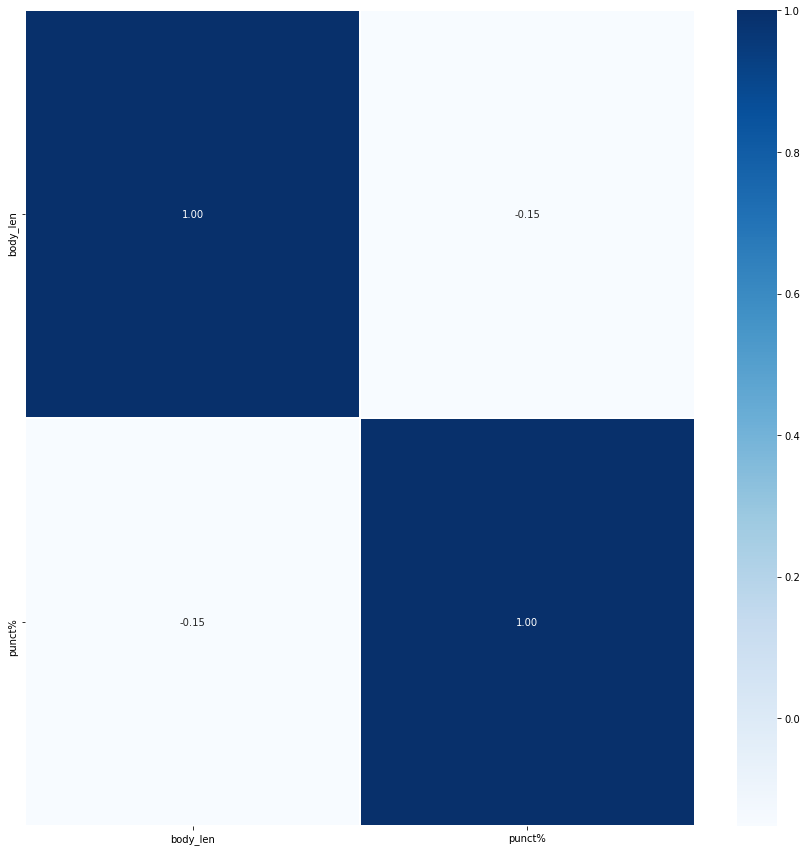

In [14]:
corr_matrx = data.corr()
fig, ax = plt.subplots(figsize = (15,15))
ax = sns.heatmap(corr_matrx,
                 annot = True,
                 linewidths = 0.5,
                 fmt = ".2f",
                 cmap = "Blues")

In [0]:
X = data.drop("label", axis = 1)
y = data["label"]

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Vectorizing our data

In [0]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

## Here we vectorized our data into train and test seperately
## Rather than vectorizing whole data set then spliting the 
## data it gives us the better accuracy to the model
tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test["body_text"])

X_features_train = pd.concat([X_train[["body_len", "punct%"]].reset_index(drop = True),
                       pd.DataFrame(tfidf_train.toarray())], axis=1)
X_features_test = pd.concat([X_test[["body_len", "punct%"]].reset_index(drop = True),
                       pd.DataFrame(tfidf_test.toarray())], axis=1)



## Modelling

#### putting all model in a dictionary simultenously

In [17]:
models = {
    "RandomForest":RandomForestClassifier(),
    "KNN":KNeighborsClassifier(),
    "GradeintBoost":GradientBoostingClassifier(),
    "LogisticRegressor":LogisticRegression()
}

## Create a function to fit and score the model
def fit_score(models, X_train,X_test,y_train, y_test):
  np.random.seed(42)
  model_score = {}
  for name, model in models.items():
    model.fit(X_train, y_train)
    model_score[name] = model.score(X_test, y_test)

  return model_score

model_scores = fit_score(models = models,
                         X_train = X_features_train,
                         X_test =X_features_test,
                         y_train = y_train,
                         y_test = y_test
                         )  

model_scores

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'GradeintBoost': 0.9721723518850988,
 'KNN': 0.9156193895870736,
 'LogisticRegressor': 0.9793536804308797,
 'RandomForest': 0.9820466786355476}

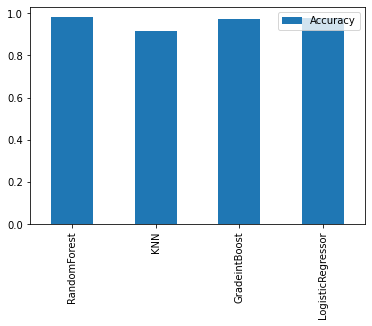

In [18]:
## model comparison
mdoel_compare = pd.DataFrame(model_scores, index = ["Accuracy"])
mdoel_compare.T.plot.bar()

## Hyperparameter tunning using GridSearchCV

In [0]:
## Create hyperparamter
log_reg = {
    "C":np.logspace(4,4,20),
    "solver":['liblinear']
}

rf_grid = {'n_estimators': [10, 150, 300],
            'max_depth':[30,60,90,None]}

gb_grid = {
    'n_estimators': [100,150],
    'max_depth': [7,11,15],
    'learning_rate':[0.1]
}




In [26]:
## Tuning the models

np.random.seed(42)
ls_reg = GridSearchCV(LogisticRegression(),
                      param_grid = log_reg,
                      cv=5,
                      verbose = True)
ls_model = ls_reg.fit(X_features_train, y_train)

rf_reg = GridSearchCV(RandomForestClassifier(),
                      param_grid = rf_grid,
                      cv=5,
                      verbose = True)

rs_model = rf_reg.fit(X_features_train, y_train)


gb_reg =GridSearchCV(GradientBoostingClassifier(),
                     param_grid = gb_grid,
                     cv=5,
                     verbose = True)
gs_model = gb_reg.fit(X_features_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   43.2s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  5.7min finished


In [42]:
rs_model.best_params_, ls_model.best_params_, gs_model.best_params_

({'max_depth': None, 'n_estimators': 150},
 {'C': 10000.0, 'solver': 'liblinear'},
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150})

In [31]:
## making prediction on the trained model
y_preds_rs =  rs_model.predict(X_features_test)
y_preds_ls =  ls_model.predict(X_features_test)
y_preds_gs =  gs_model.predict(X_features_test)

y_score_rs =  rs_model.score(X_features_test, y_test)
y_score_ls =  ls_model.score(X_features_test, y_test)
y_score_gs =  gs_model.score(X_features_test, y_test)

print(y_score_rs)
print(y_score_ls)
print(y_score_gs)

0.9820466786355476
0.9901256732495511
0.981149012567325


In [56]:
Predictions = pd.DataFrame(y_test)
Predictions
Predictions["RandomForest"] = y_preds_rs
Predictions["LogisticRegression"] = y_preds_ls
Predictions["GradientBoosting"] = y_preds_gs
Predictions.head()

,label,RandomForest,LogisticRegression,GradientBoosting
1168,ham,ham,ham,ham
765,ham,ham,ham,ham
465,ham,ham,ham,ham
1117,spam,spam,spam,spam
4930,ham,ham,ham,ham


## Classification Report

In [30]:
## Classification report of the models
print(classification_report(y_test, y_preds_rs))
print(classification_report(y_test, y_preds_ls))
print(classification_report(y_test, y_preds_gs))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       967
        spam       1.00      0.86      0.93       147

    accuracy                           0.98      1114
   macro avg       0.99      0.93      0.96      1114
weighted avg       0.98      0.98      0.98      1114

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       967
        spam       0.97      0.95      0.96       147

    accuracy                           0.99      1114
   macro avg       0.98      0.97      0.98      1114
weighted avg       0.99      0.99      0.99      1114

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       967
        spam       0.96      0.90      0.93       147

    accuracy                           0.98      1114
   macro avg       0.97      0.95      0.96      1114
weighted avg       0.98      0.98      0.98      1114



In [32]:
print(confusion_matrix(y_test, y_preds_rs))

[[967   0]
 [ 20 127]]


## Confusion Matrix

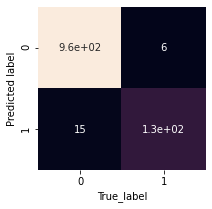

In [33]:
## Create a function to plot a confusion matrix
def plot_conf(y_test, y_preds):
  fig, ax = plt.subplots(figsize = (3,3))
  ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                   annot = True,
                   cbar = False)
  plt.xlabel("True_label")
  plt.ylabel("Predicted label")

plot_conf(y_test, y_preds_gs)  

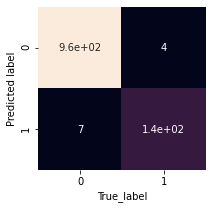

In [34]:
plot_conf(y_test, y_preds_ls)

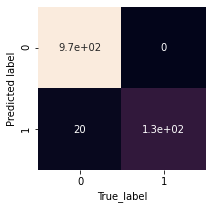

In [35]:
plot_conf(y_test, y_preds_rs)

## Plotting the ROC and AUC curve

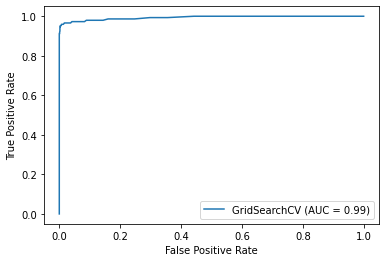

In [36]:
## function for plotting roc curve

def plot_roc(model, X_features_test, y_test):
  plot_roc_curve(model, X_features_test, y_test)


plot_roc(rs_model, X_features_test, y_test)


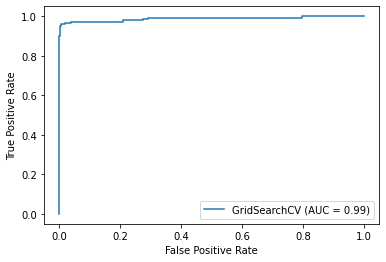

In [37]:
plot_roc(ls_model, X_features_test, y_test)

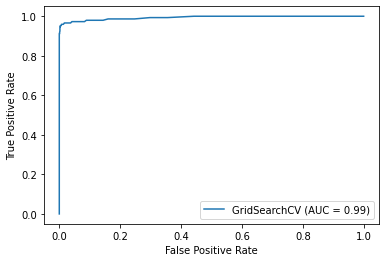

In [39]:
plot_roc(rs_model, X_features_test, y_test)